In [2]:
import pandas as pd

In [3]:
training_data = pd.read_parquet('C:/Users/nguye/Downloads/BTCUSDT/')

labels = pd.read_parquet('C:/Users/nguye/Downloads/LABEL_BTCUSDT/')

In [4]:
labels.index = labels.index.astype('int64')
labels.drop(columns="SYMBOL",inplace=True)

In [34]:
print(training_data.head())
print(labels)

                  OPEN     HIGH      LOW    CLOSE    VOLUME  \
OPEN_TIME                                                     
1502942400000  4261.48  4280.56  4261.48  4261.48  2.189061   
1502942700000  4261.48  4261.48  4261.48  4261.48  0.000000   
1502943000000  4261.48  4261.48  4261.48  4261.48  0.000000   
1502943300000  4261.48  4264.88  4261.48  4261.48  0.484666   
1502943600000  4264.88  4266.29  4264.88  4266.29  2.328570   

               QUOTE_ASSET_VOLUME  NUMBER_OF_TRADES  \
OPEN_TIME                                             
1502942400000         9333.620962                 9   
1502942700000            0.000000                 0   
1502943000000            0.000000                 0   
1502943300000         2065.447829                 9   
1502943600000         9931.161124                11   

               TAKER_BUY_BASE_ASSET_VOLUME  TAKER_BUY_QUOTE_ASSET_VOLUME  \
OPEN_TIME                                                                  
1502942400000       

In [22]:
join_data = training_data.join(labels, how='left')


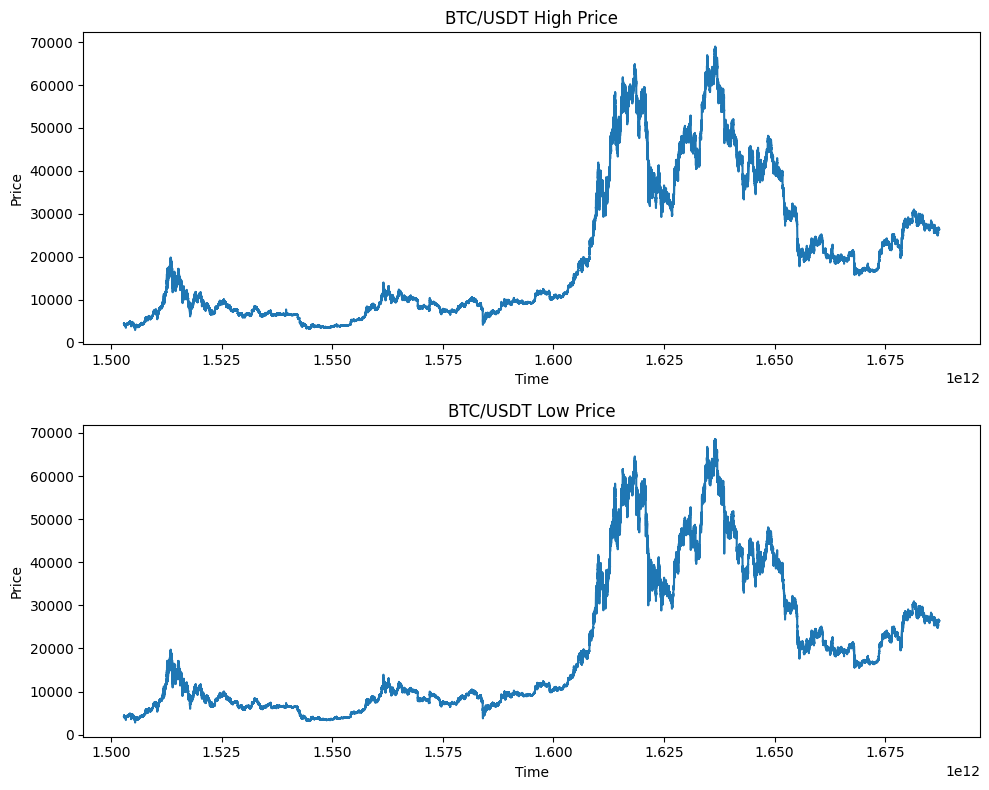

In [35]:
import matplotlib.pyplot as plt

# set figure size
fig = plt.figure(figsize=(10, 8))

# plot line chart of High column
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(training_data['HIGH'])
ax1.set_title('BTC/USDT High Price')
ax1.set_xlabel('Time')
ax1.set_ylabel('Price')

# plot line chart of Low column
ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(training_data['LOW'])
ax2.set_title('BTC/USDT Low Price')
ax2.set_xlabel('Time')
ax2.set_ylabel('Price')

# display plot
plt.tight_layout()
plt.show()


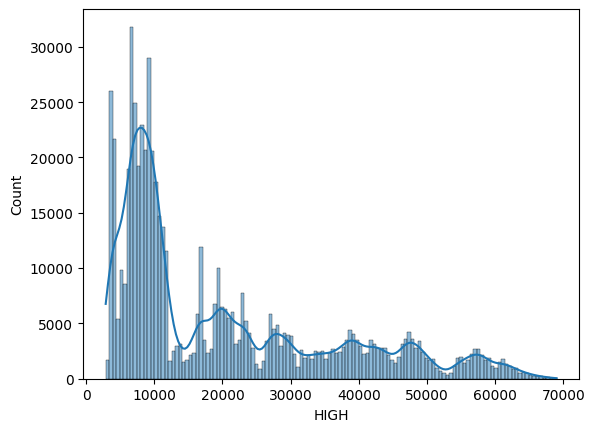

In [32]:
import seaborn as sns
sns.histplot(training_data['HIGH'], kde=True)
plt.show()